### Lab 3. Detección de Malware

#### Miembros
- Fernanda Esquivel - 21542
- Andrés Montoya - 21552

#### Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/SDS-Lab-03)

# Primer modelo

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report

In [4]:
df = pd.read_csv('dataset/MalBehav.csv')

In [19]:
#Mostrar información del dataset
print(f"Dimensiones del dataset: {df.shape}")
print(f"\nPrimeras 5 filas del dataset:")
print(df.head())

Dimensiones del dataset: (2570, 178)

Primeras 5 filas del dataset:
                                              sha256  labels  \
0  5c18291c481a192ed5003084dab2d8a117fd3736359218...       0   
1  4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...       0   
2  9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...       0   
3  e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...       0   
4  ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...       0   

                     0                        1                   2  \
0         LdrUnloadDll           CoUninitialize          NtQueryKey   
1         NtOpenMutant      GetForegroundWindow          NtQueryKey   
2  GetForegroundWindow              DrawTextExW       GetSystemInfo   
3      NtQueryValueKey             LdrUnloadDll  GlobalMemoryStatus   
4         LdrUnloadDll  GetSystemTimeAsFileTime           NtOpenKey   

                   3                            4                       5  \
0  NtDuplicateObject            GetShortPat

In [20]:
#Comprobar valores nulos
print(f"\nValores nulos por columna:")
print(df.isnull().sum().sum())


Valores nulos por columna:
338757


In [21]:
#Distribución de clases
print(f"\nDistribución de clases:")
print(df['labels'].value_counts())


Distribución de clases:
labels
0    1285
1    1285
Name: count, dtype: int64


## Pre-procesamiento

In [22]:
#Convertir secuencias de API calls en una sola cadena de texto
def joinAPICalls(row):
    api_calls = []
    #Excluimos columnas que no son API calls (sha256 y labels)
    for col in range(0, 153):  # De 0 a 152
        if pd.notna(row[str(col)]) and row[str(col)] != "":
            api_calls.append(row[str(col)])
    return " ".join(api_calls)

In [23]:
#Crear una nueva columna con las secuencias de API unidas
df['api_sequence'] = df.apply(joinAPICalls, axis=1)

In [24]:
#Verificar cuántas secuencias están vacías
empty_sequences = df['api_sequence'].str.strip().eq('').sum()
print(f"Secuencias vacías: {empty_sequences}")

Secuencias vacías: 0


In [25]:
#Eliminar filas con secuencias vacías si existen
if empty_sequences > 0:
    df = df[df['api_sequence'].str.strip() != '']
    print(f"Dataset después de eliminar secuencias vacías: {df.shape}")

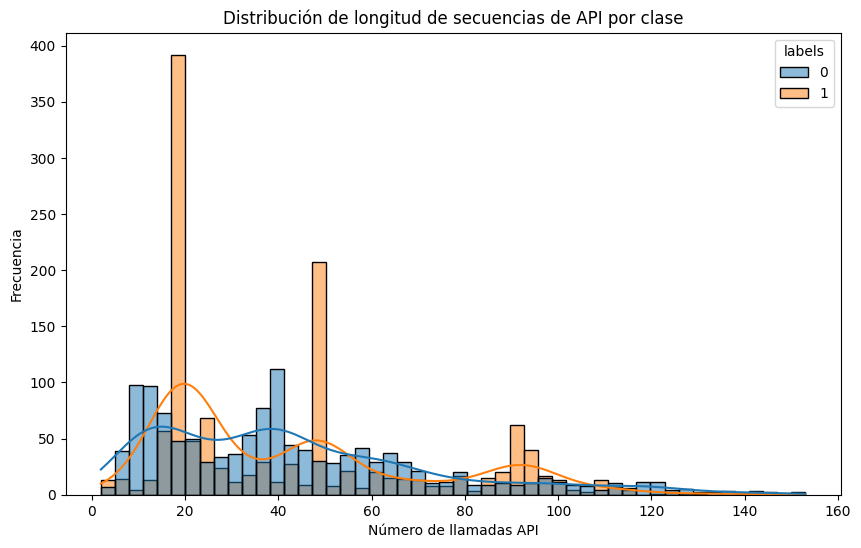

In [26]:
#Visualizar la longitud de las secuencias
df['sequence_length'] = df['api_sequence'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='sequence_length', hue='labels', bins=50, kde=True)
plt.title('Distribución de longitud de secuencias de API por clase')
plt.xlabel('Número de llamadas API')
plt.ylabel('Frecuencia')
plt.show()

## Ingeniería de Características

In [27]:
#Dividir los datos en entrenamiento y prueba antes de aplicar TF-IDF
X = df['api_sequence']
y = df['labels']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamaño conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño conjunto de pruebas: {X_test.shape[0]} muestras")

Tamaño conjunto de entrenamiento: 1799 muestras
Tamaño conjunto de pruebas: 771 muestras


In [29]:
#Aplicar TF-IDF a las secuencias de API
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Limitamos a 1000 características para controlar dimensionalidad
    min_df=5,           # Ignorar términos que aparecen en menos de 5 documentos
    max_df=0.7,         # Ignorar términos que aparecen en más del 70% de los documentos
    ngram_range=(1, 2)  # Considerar unigramas y bigramas
)

In [30]:
#Ajustar y transformar los datos de entrenamiento
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
#Transformar los datos de prueba con el mismo vectorizador
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Dimensiones de la matriz TF-IDF de entrenamiento: {X_train_tfidf.shape}")
print(f"Dimensiones de la matriz TF-IDF de prueba: {X_test_tfidf.shape}")

Dimensiones de la matriz TF-IDF de entrenamiento: (1799, 1000)
Dimensiones de la matriz TF-IDF de prueba: (771, 1000)


In [31]:
#Visualizar las 20 características más importantes según TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_mean = X_train_tfidf.mean(axis=0).A1
top_features = sorted(zip(tfidf_mean, feature_names), reverse=True)[:20]

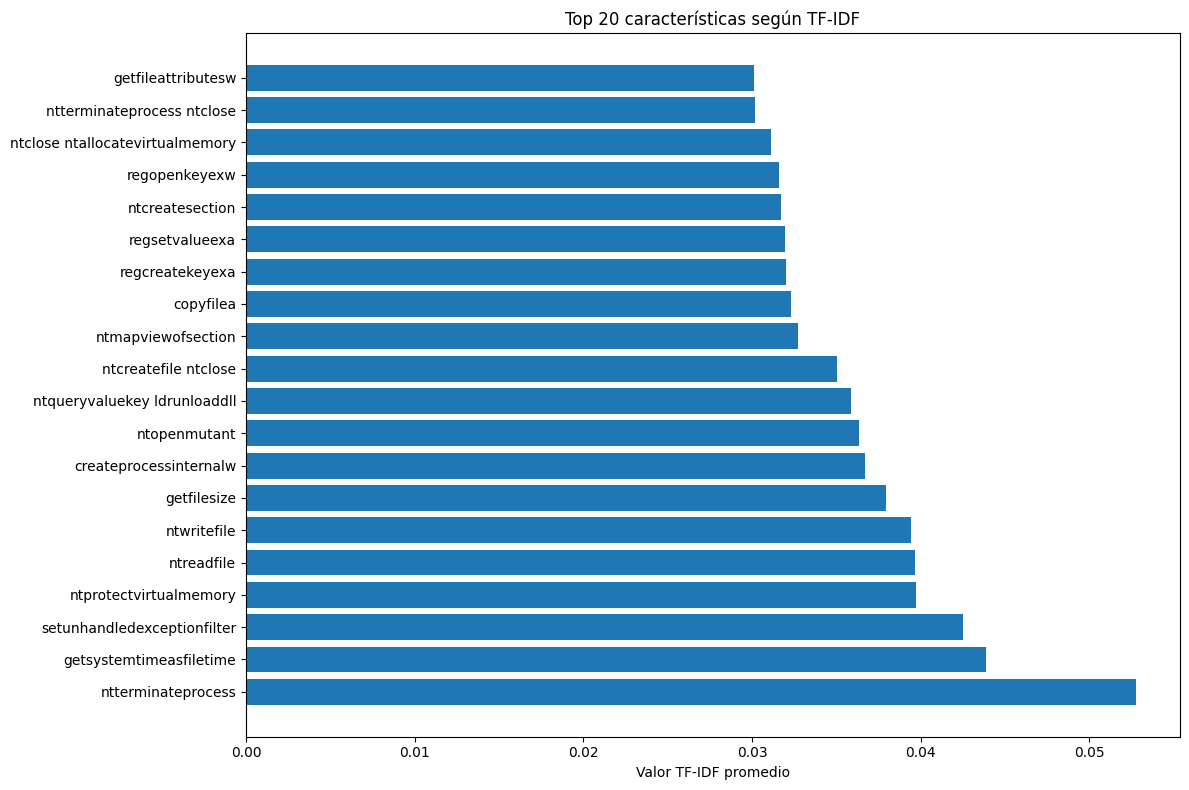

In [32]:
plt.figure(figsize=(12, 8))
values = [x[0] for x in top_features]
labels = [x[1] for x in top_features]
plt.barh(labels, values)
plt.title('Top 20 características según TF-IDF')
plt.xlabel('Valor TF-IDF promedio')
plt.tight_layout()
plt.show()

## Implementación del Modelo (TF-IDF)

In [33]:
#Seleccionamos Random Forest como clasificador
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

In [34]:
#Entrenamiento del modelo
clf.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)

In [35]:
#Hacer predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_tfidf)
y_pred_proba = clf.predict_proba(X_test_tfidf)[:, 1]

## Validación del Modelo

In [36]:
#Métricas de rendimiento
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [37]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9637
Precision: 0.9890
Recall: 0.9377


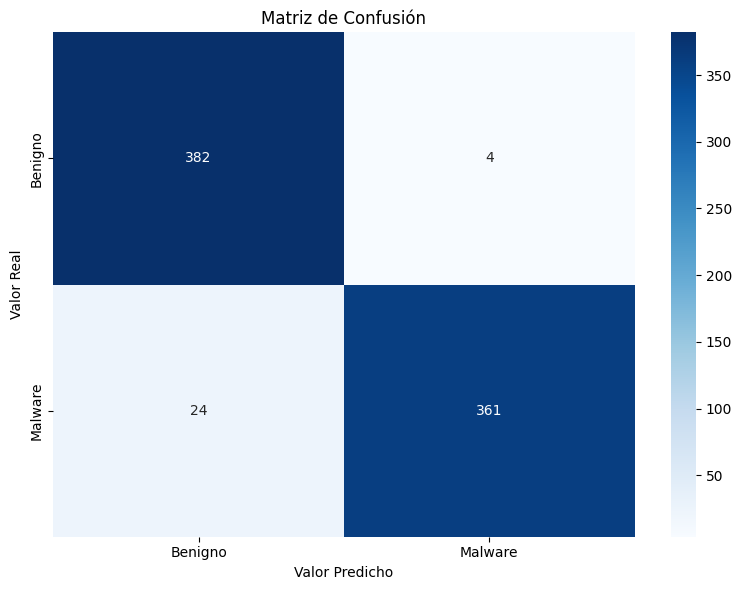

In [38]:
#Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benigno', 'Malware'],
            yticklabels=['Benigno', 'Malware'])
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.tight_layout()
plt.show()

In [39]:
#Reporte de clasificación detallado
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Benigno', 'Malware']))


Reporte de clasificación:
              precision    recall  f1-score   support

     Benigno       0.94      0.99      0.96       386
     Malware       0.99      0.94      0.96       385

    accuracy                           0.96       771
   macro avg       0.96      0.96      0.96       771
weighted avg       0.96      0.96      0.96       771



## Validación con K-Fold

In [ ]:
#Definir las métricas a evaluar (k = 10)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

In [42]:
#Realizar validación cruzada con 10-folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(clf, X_train_tfidf, y_train, cv=kf, scoring=scoring)

In [43]:
#Imprimir resultados de validación cruzada
for metric in scoring.keys():
    print(f"CV {metric}: {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")

CV accuracy: 0.9583 ± 0.0140
CV precision: 0.9782 ± 0.0234
CV recall: 0.9358 ± 0.0182
CV f1: 0.9564 ± 0.0178


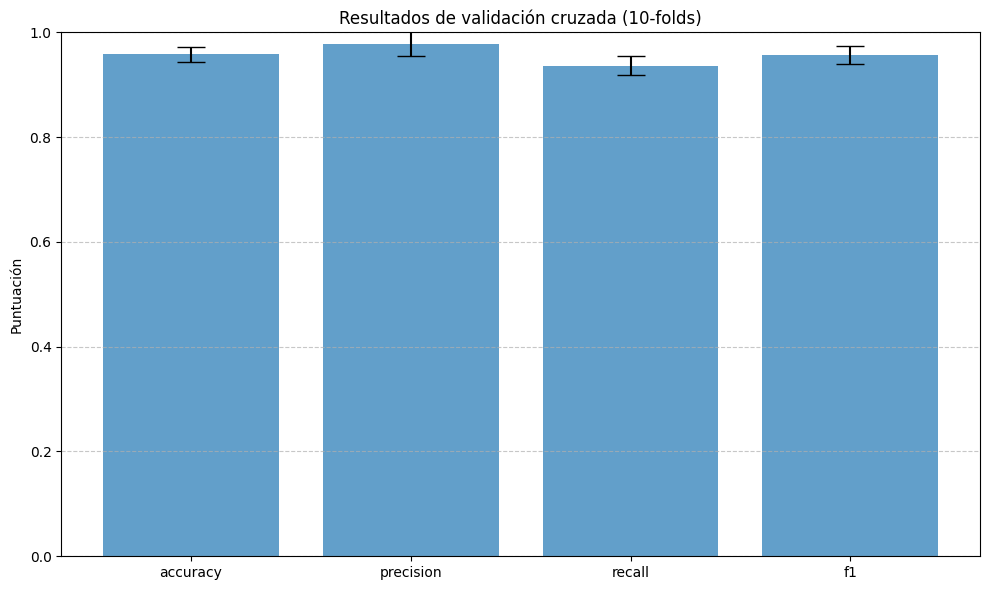

In [44]:
#Visualizar resultados de validación cruzada
plt.figure(figsize=(10, 6))
metrics = list(scoring.keys())
values = [cv_results[f'test_{m}'].mean() for m in metrics]
errors = [cv_results[f'test_{m}'].std() for m in metrics]

plt.bar(metrics, values, yerr=errors, capsize=10, alpha=0.7)
plt.ylim(0, 1.0)
plt.title('Resultados de validación cruzada (10-folds)')
plt.ylabel('Puntuación')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Curva ROC

In [45]:
#Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

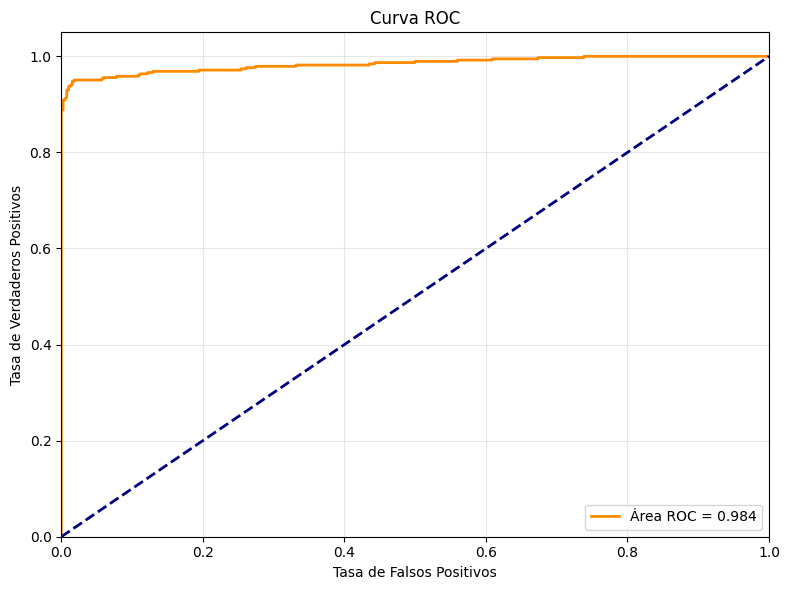

In [46]:
#Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Área ROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Análisis de importancia de Características

In [47]:
#Obtener la importancia de las características
feature_importance = clf.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

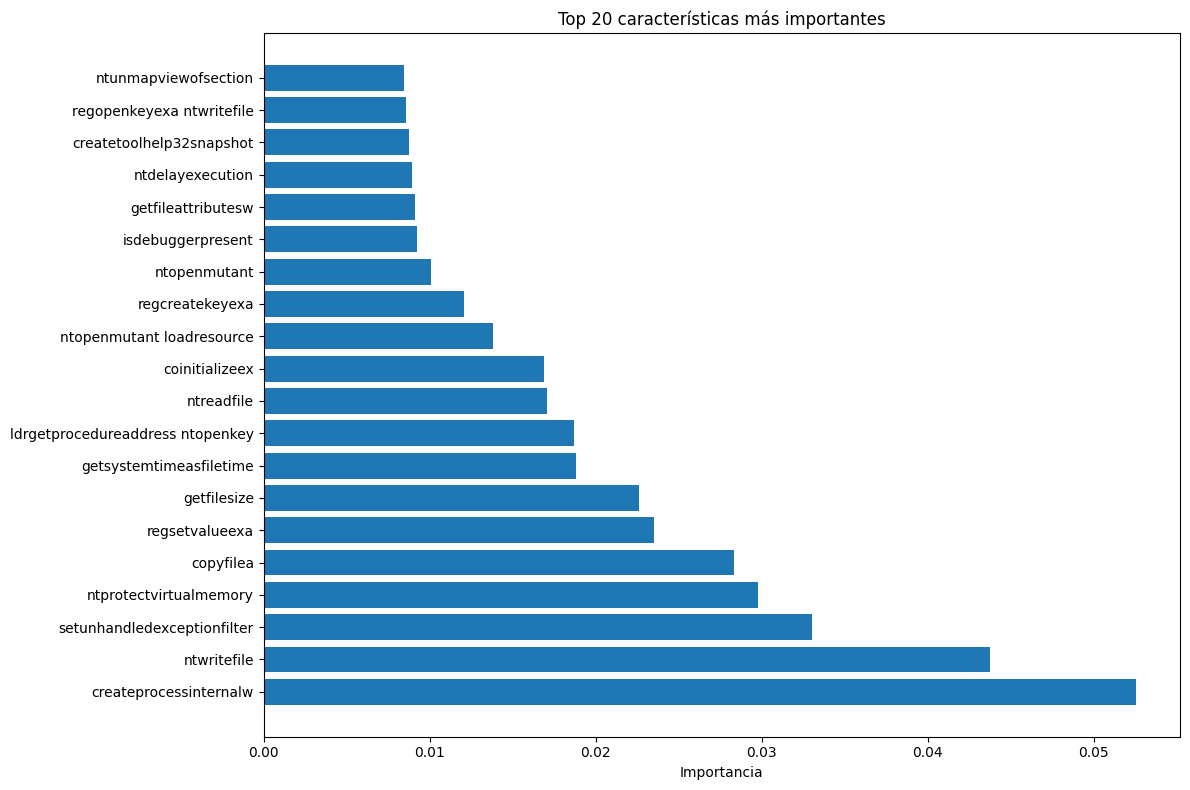

In [48]:
#Ordenar las características por importancia
indices = np.argsort(feature_importance)[::-1]
top_n = 20  # Mostrar las 20 características más importantes

plt.figure(figsize=(12, 8))
plt.title('Top 20 características más importantes')
plt.barh(range(top_n), feature_importance[indices][:top_n], align='center')
plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]])
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

## Resultados del primer modelo

In [49]:
print(f"""
Resumen del modelo:
- Método: Random Forest con representación TF-IDF de secuencias API
- Accuracy: {accuracy:.4f}
- Precision: {precision:.4f}
- Recall: {recall:.4f}
- AUC-ROC: {roc_auc:.4f}
""")


Resumen del modelo:
- Método: Random Forest con representación TF-IDF de secuencias API
- Accuracy: 0.9637
- Precision: 0.9890
- Recall: 0.9377
- AUC-ROC: 0.9841

